<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/est0123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📥 Loading Living data from: リビング.csv ...
Resampling to 1min...
Building features...

  [Living] Analysis (Split Files)
  Features: 822
  Train: 17591, Test: 7560
  Test Label Dist: {0: 6901, 2: 333, 1: 326}

--- Result: Living (Threshold=0.3) ---
              precision    recall  f1-score   support

           0      0.997     0.985     0.991      6901
           1      0.792     0.911     0.847       326
           2      0.723     0.793     0.756       333

    accuracy                          0.973      7560
   macro avg      0.837     0.896     0.865      7560
weighted avg      0.976     0.973     0.974      7560



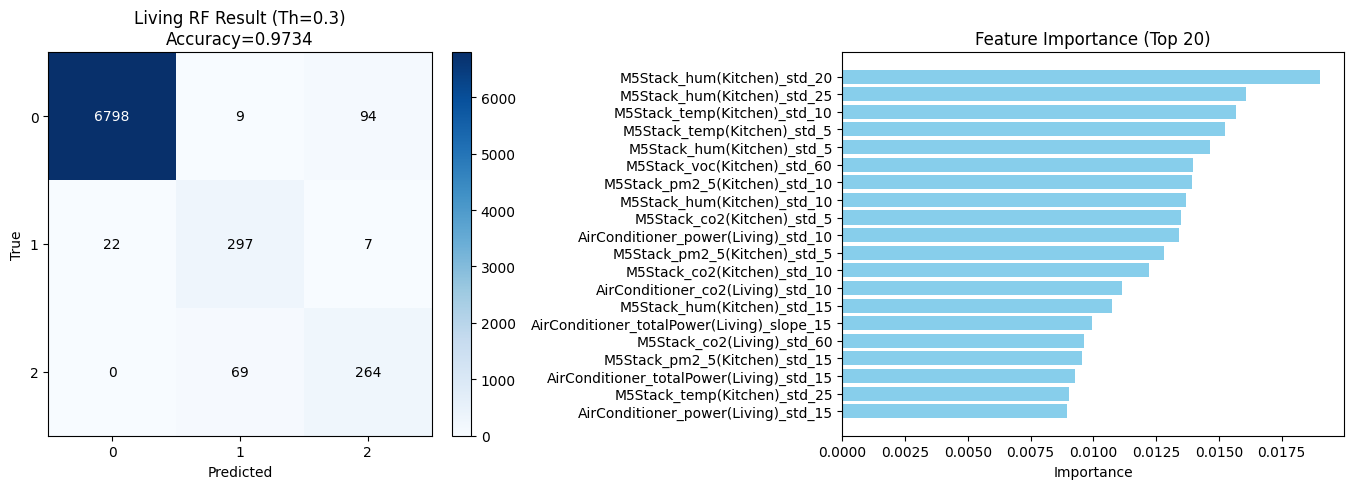


📥 Loading Japanese data from: 和室.csv ...
Resampling to 1min...
Building features...

  [Japanese] Analysis (Split Files)
  Features: 683
  Train: 17527, Test: 7560
  Test Label Dist: {0: 7121, 2: 227, 1: 212}

--- Result: Japanese (Threshold=0.3) ---
              precision    recall  f1-score   support

           0      0.999     0.995     0.997      7121
           1      0.807     0.986     0.887       212
           2      0.995     0.916     0.954       227

    accuracy                          0.992      7560
   macro avg      0.934     0.966     0.946      7560
weighted avg      0.993     0.992     0.992      7560



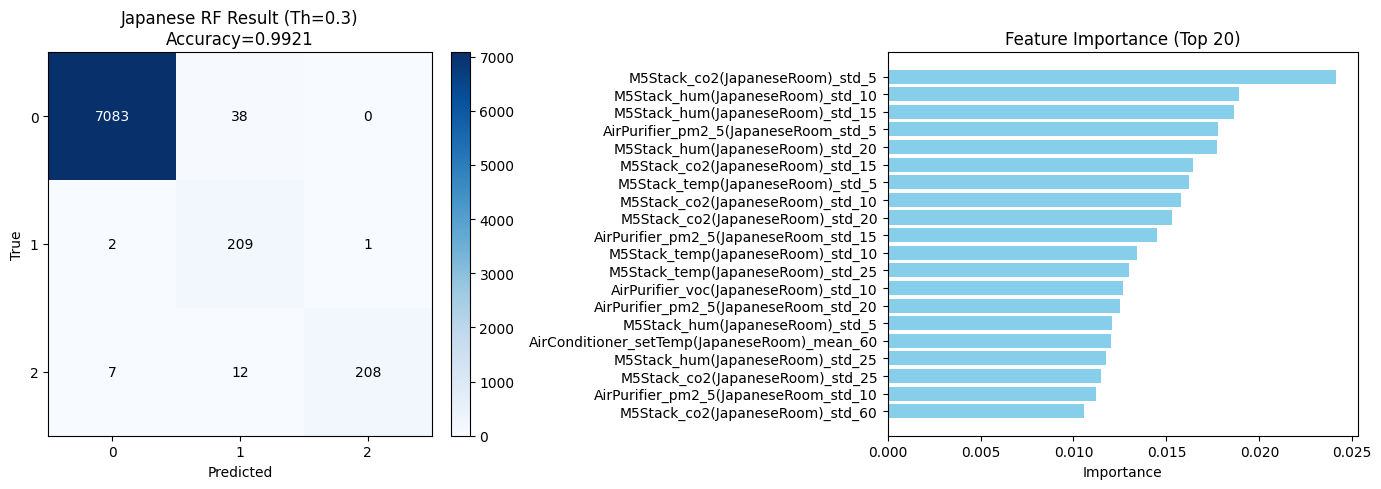


✅ Done.


In [8]:
# ============================================================
# Room-Specific Analysis (Split Files) - All Sensors + Appliances
# Weighted RF with Custom Threshold
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

# データの分割設定
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 閾値設定 (見逃し防止)
THRESHOLD_OCCUPIED = 0.30

# 除外するラベル列
LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People" # Just in case
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    print("⚠️ タイムスタンプ補正を実行中...")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    if importances is not None:
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        top = imp.head(topk)[::-1]
        ax2.barh(top.index, top.values, color="skyblue")
        ax2.set_title(f"Feature Importance (Top {topk})")
        ax2.set_xlabel("Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Model & Prediction
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def predict_with_threshold(model, X, threshold=0.3):
    """確率閾値による判定"""
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)

    for i in range(len(preds)):
        p0, p1, p2 = probs[i]
        # 0(不在)と判定されても、1or2の確率が閾値を超えていれば書き換え
        if preds[i] == 0:
            if p1 >= threshold or p2 >= threshold:
                preds[i] = 1 if p1 >= p2 else 2
    return preds

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        raise ValueError(f"CSVに {TIME_COL} 列がありません。")
    if target_col not in df0.columns:
        raise ValueError(f"ラベル列 {target_col} がありません。")

    # Timestamp & Resample
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    # ラベル
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # 特徴量選択 (全カラムからラベル以外を取得、種別判定)
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    # Human/PIR vs Numeric separation
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    # 特徴量作成
    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis (Split Files)")
    print(f"  Features: {X.shape[1]}")
    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    # Train
    model = rf_model()
    model.fit(X_tr, y_tr)

    # Predict
    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Result: {room} (Threshold={THRESHOLD_OCCUPIED}) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"{room} RF Result (Th={THRESHOLD_OCCUPIED})",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )

# =========================
# Main Execution
# =========================
# Run for Living
run_room_file_analysis("リビング.csv", "Living", "Label_Living_Count")

# Run for Japanese
run_room_file_analysis("和室.csv", "Japanese", "Label_Japanese_Count")

print("\n✅ Done.")


📥 Loading Living data from: /content/リビング_家電のみ.csv ...
Resampling to 1min...
Building features...

  [Living] Analysis (Standard Prediction with Threshold 0.25)
  Features: 506
  Test Label Dist: {0: 6901, 2: 333, 1: 326}
Applying threshold 0.25 to predictions...

--- Result: Living (Threshold 0.25) ---
              precision    recall  f1-score   support

           0      0.997     0.981     0.989      6901
           1      0.814     0.887     0.849       326
           2      0.663     0.829     0.737       333

    accuracy                          0.971      7560
   macro avg      0.825     0.899     0.858      7560
weighted avg      0.975     0.971     0.972      7560



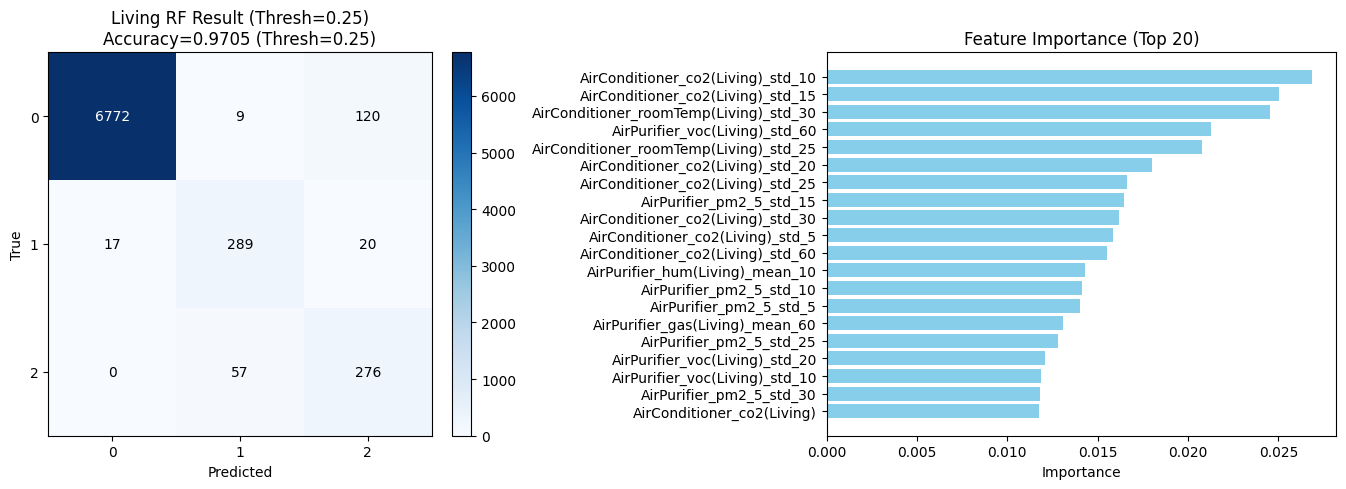


--- Top 20 Feature Importances ---
AirConditioner_co2(Living)_std_10         0.026856
AirConditioner_co2(Living)_std_15         0.025054
AirConditioner_roomTemp(Living)_std_30    0.024557
AirPurifier_voc(Living)_std_60            0.021290
AirConditioner_roomTemp(Living)_std_25    0.020752
AirConditioner_co2(Living)_std_20         0.018014
AirConditioner_co2(Living)_std_25         0.016604
AirPurifier_pm2_5_std_15                  0.016435
AirConditioner_co2(Living)_std_30         0.016160
AirConditioner_co2(Living)_std_5          0.015871
AirConditioner_co2(Living)_std_60         0.015535
AirPurifier_hum(Living)_mean_10           0.014277
AirPurifier_pm2_5_std_10                  0.014147
AirPurifier_pm2_5_std_5                   0.014019
AirPurifier_gas(Living)_mean_60           0.013094
AirPurifier_pm2_5_std_25                  0.012781
AirPurifier_voc(Living)_std_20            0.012059
AirPurifier_voc(Living)_std_10            0.011847
AirPurifier_pm2_5_std_30                  0.01

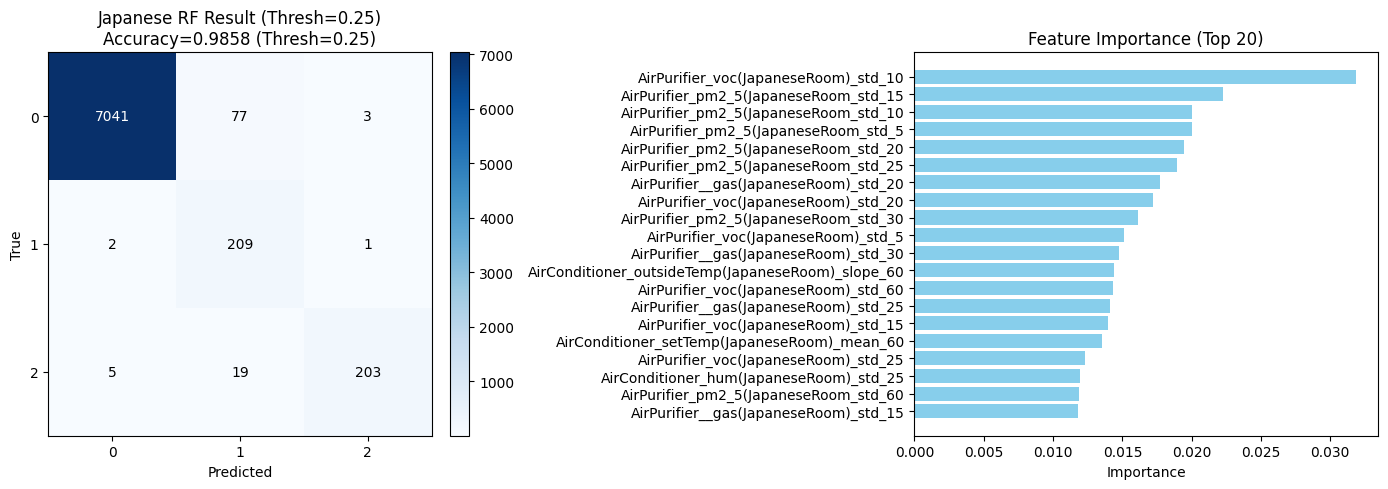


--- Top 20 Feature Importances ---
AirPurifier_voc(JapaneseRoom)_std_10                 0.031852
AirPurifier_pm2_5(JapaneseRoom_std_15                0.022285
AirPurifier_pm2_5(JapaneseRoom_std_10                0.020028
AirPurifier_pm2_5(JapaneseRoom_std_5                 0.020027
AirPurifier_pm2_5(JapaneseRoom_std_20                0.019435
AirPurifier_pm2_5(JapaneseRoom_std_25                0.018927
AirPurifier__gas(JapaneseRoom)_std_20                0.017717
AirPurifier_voc(JapaneseRoom)_std_20                 0.017204
AirPurifier_pm2_5(JapaneseRoom_std_30                0.016150
AirPurifier_voc(JapaneseRoom)_std_5                  0.015125
AirPurifier__gas(JapaneseRoom)_std_30                0.014780
AirConditioner_outsideTemp(JapaneseRoom)_slope_60    0.014397
AirPurifier_voc(JapaneseRoom)_std_60                 0.014356
AirPurifier__gas(JapaneseRoom)_std_25                0.014107
AirPurifier_voc(JapaneseRoom)_std_15                 0.013974
AirConditioner_setTemp(JapaneseRoo

In [15]:
# ============================================================
# Room-Specific Analysis (Threshold = 0.30)
# Output Feature Importance List
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# ★★★ 閾値を0.30に設定 ★★★
THRESHOLD = 0.25

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f} (Thresh={THRESHOLD})")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top {topk})")
    ax2.set_xlabel("Importance")

    plt.tight_layout()
    plt.show()

def print_top_features(feature_names, importances, topk=20):
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print(f"\n--- Top {topk} Feature Importances ---")
    print(imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: CSVに {TIME_COL} 列がありません。")
        return
    if target_col not in df0.columns:
        print(f"Error: ラベル列 {target_col} がありません。")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # All non-label columns as features
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis (Standard Prediction with Threshold {THRESHOLD})")
    print(f"  Features: {X.shape[1]}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    model = rf_model()
    model.fit(X_tr, y_tr)

    # --- 閾値適用ロジック ---
    print(f"Applying threshold {THRESHOLD} to predictions...")
    probs = model.predict_proba(X_te)
    classes = model.classes_

    final_pred = []
    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}

        # 0以外のクラス（1, 2）の中で、確率がTHRESHOLD以上のものを抽出
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD}

        if candidates:
            # 候補があれば、その中で最も確率が高いクラスを採用
            best_c = max(candidates, key=candidates.get)
            final_pred.append(best_c)
        else:
            # 閾値を超える「存在」クラスがなければ 0 (不在) と判定
            final_pred.append(0)

    final_pred = np.array(final_pred)
    # ---------------------------

    print(f"\n--- Result: {room} (Threshold {THRESHOLD}) ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Plot and Print Importance
    plot_cm_and_importance(
        f"{room} RF Result (Thresh={THRESHOLD})",
        y_te, final_pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )
    print_top_features(X.columns, model.feature_importances_, TOPK_IMPORTANCE)

# =========================
# Main
# =========================
if __name__ == "__main__":
    run_room_file_analysis("/content/リビング_家電のみ.csv", "Living", "Label_Living_Count")
    run_room_file_analysis("/content/和室_家電のみ.csv", "Japanese", "Label_Japanese_Count")